## 9.5 机器翻译与数据集

In [41]:
import os
import torch
from d2l import torch as d2l

In [5]:
# 下载和预处理数据集
#@save
d2l.DATA_HUB['fra-eng']=(d2l.DATA_URL+'fra-eng.zip',
                        '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入英语-法语数据集"""
    data_dir=d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir,'fra.txt'),'r',encoding='utf8') as f:
        return f.read()
    
raw_text=read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [21]:
# 预处理数据集
#@save
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text=preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [9]:
# 词元化
#@save
def tokenize_nmt(text, num_examples=None):
    source, target=[],[]
    for i, line in enumerate(text.split('\n')):
        if num_examples and i>num_examples:
            break
        parts=line.split('\t')
        if len(parts)==2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target=tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

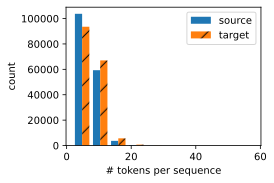

In [12]:
# 绘制词元直方图
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    d2l.set_figsize()
    _,_,patches=d2l.plt.hist([
        [len(l) for l in xlist], [len(l) for l in ylist]
    ])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)
    
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target)

In [45]:
# 构建词表
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [48]:
# 查看词汇表中的词汇及对应的索引
print(src_vocab.token_to_idx)

{'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3, '.': 4, 'i': 5, 'you': 6, 'to': 7, 'the': 8, '?': 9, 'a': 10, 'is': 11, 'tom': 12, 'that': 13, 'he': 14, 'do': 15, 'of': 16, 'it': 17, 'this': 18, 'in': 19, 'me': 20, 'have': 21, "don't": 22, ',': 23, 'was': 24, 'my': 25, 'are': 26, 'for': 27, 'your': 28, 'what': 29, "i'm": 30, 'we': 31, 'be': 32, 'want': 33, 'she': 34, 'not': 35, 'know': 36, 'like': 37, 'on': 38, 'with': 39, 'can': 40, 'his': 41, 'all': 42, 'did': 43, 'at': 44, "you're": 45, 'how': 46, 'go': 47, 'they': 48, 'him': 49, 'think': 50, 'and': 51, "it's": 52, 'about': 53, 'time': 54, "can't": 55, 'here': 56, 'very': 57, "didn't": 58, 'get': 59, 'there': 60, 'her': 61, 'were': 62, 'as': 63, 'will': 64, 'had': 65, 'if': 66, 'why': 67, 'just': 68, 'up': 69, 'out': 70, 'no': 71, 'has': 72, 'one': 73, 'going': 74, 'would': 75, 'so': 76, 'good': 77, 'need': 78, 'tell': 79, 'an': 80, 'see': 81, "i'll": 82, 'come': 83, 'when': 84, 'from': 85, 'by': 86, 'really': 87, 'mary': 88, 'help

In [57]:
# 截断或填充文本序列
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line)>num_steps:
        return line[:num_steps]
    return line+[padding_token]*(num_steps-len(line))

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [22]:
# 将机器翻译的文本序列转换成小批量

#@save
def build_array_nmt(lines, vocab, num_steps):
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [23]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [24]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[  9, 173, 118,   4,   3,   1,   1,   1],
        [ 39,   0,   5,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([5, 4])
Y: tensor([[ 45,  46, 151,   5,   3,   1,   1,   1],
        [ 47,  12, 106,   5,   3,   1,   1,   1]], dtype=torch.int32)
Y的有效长度: tensor([5, 5])
